<a href="https://colab.research.google.com/github/ZahraDehghani99/Digital-Image-Processing/blob/main/HW2/DIP_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acute Lymphoblastic Leukemia (ALL) Classifier

## Load required libraries

In [1]:
import glob
import random
import cv2
from pathlib import Path
import numpy as np
from numpy.random import seed
import pandas as pd
from google.colab.patches import cv2_imshow

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from scipy import ndimage
from skimage import exposure
import skimage
import seaborn as sns

import tensorflow as tf
from keras.utils import np_utils
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Flatten,Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Convolution2D, Dropout, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, SeparableConv2D, Input,GaussianNoise
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras import backend as K

%matplotlib inline

In [2]:
# for consistemt results across multiple executions
seed(3)
tf.random.set_seed(3)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading dataset

In [ ]:
# !pip install unrar
# !unrar x '/content/drive/MyDrive/DIP/HW2/ALL_IDB2.rar' '/content/drive/MyDrive/DIP/HW2'

## Create dataframe for dataset

In [ ]:
images_dir = Path('/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img')
images = images_dir.glob("*.tif")

data = []
for img in images:
  img_address = str(img)
  partition = img_address.rpartition('.') # ('/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img/Im260_0', '.', 'tif')
  if partition[0][-1] == "1":             # label of image
    data.append((img,1))    
  else:
    data.append((img,0))

print(f'len of data : {len(data)}')    
data = pd.DataFrame(data,columns=['image','label'],index = None)
data = data.sample(frac=1.).reset_index(drop=True)

len of data : 260


In [4]:
# data.to_csv('/content/drive/MyDrive/DIP/HW2/train_data.csv', index=False)
data = pd.read_csv('/content/drive/MyDrive/DIP/HW2/train_data.csv')
data.head()

,image,label
0,/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img/Im...,0
1,/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img/Im...,0
2,/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img/Im...,1
3,/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img/Im...,1
4,/content/drive/MyDrive/DIP/HW2/ALL_IDB2/img/Im...,0


## Plot imges for each class

Let's plot an image and see it's shape.

image shape => (257, 257, 3)

Non_ALL


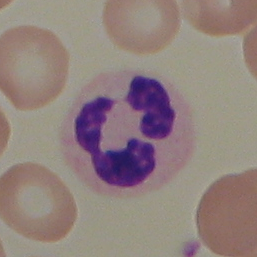

In [ ]:
image = cv2.imread(str(data.iloc[0]['image']), -1)
print(f'image shape => {image.shape}')
if data.iloc[0]['label'] == 1:
  print(f'\nALL')
else:
  print(f'\nNon_ALL')  
cv2_imshow(image)

Now, we want to plot 5 examples for each class.

Non_ALL


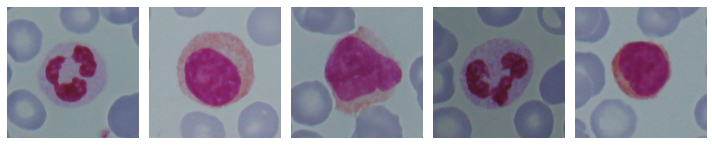

ALL


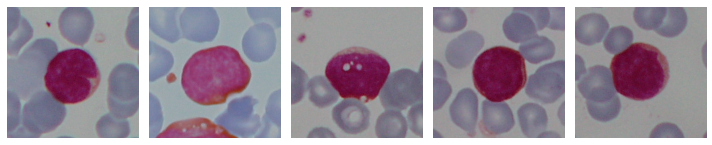

In [ ]:
# Gather 5 Example images per label
labels = ['Non_ALL', 'ALL']
n_classes = 2
examples_per_sign = 5
total = 0
example = {}
for (img,label) in zip(data.image, data.label):
    example.setdefault(int(label), [])
    if len(example[int(label)]) < examples_per_sign:
        example[int(label)].append(str(img))
        total += 1
    if total == n_classes * examples_per_sign:
        break;

for label in sorted(example.keys()):
    fig = plt.figure(figsize=(10, 8))
    print(labels[label])
    for i in range(examples_per_sign):
        plt.subplot(1,examples_per_sign,i+1)
        img = cv2.imread(example[label][i], -1)
        plt.axis('off')
        plt.imshow(img)
    plt.tight_layout()    
    plt.show()

اول میایم داده هامون رو به فرمت قابل قبول برای دادن به شبکه عصبی یا هر کلاسیفایر دیگه تبدیل می کنیم. به اینصورت که یک آرایه از نام پای برای ويژگی ها تشکیل می دهیم که لازمه اش اینه که سایز تمام تصاویر را به یک فرمت در آوریم و باید تصاویر رو هم نرمال بکنیم و در این ماتریس قرار دهیم. و بعدش باید برای برچسب هامون هم یک آرایه در نظر بگیریم.

تصاویر در ابعاد مختلفی در داده های ما وجود دارند.

In [ ]:
image = cv2.imread(str(data.iloc[79]['image']), -1)
image.shape

(257, 193, 3)

## Preprocessing images

### Define preprocessing function

In [ ]:
def data_preprocessing(dataframe, dim):

  n = dataframe.shape[0]
  images = np.zeros((n,dim,dim,3),dtype = np.float32)
  labels = np.zeros((n,2),dtype = np.float32)
  for i in range(n):
    img = cv2.imread(str(dataframe.iloc[i]['image'])) 
    img = cv2.resize(img, (dim,dim))
    encoded_label = np_utils.to_categorical(data.iloc[i]['label'], num_classes=2)
    orig_img = img.astype(np.float32)/255.           
    images[i] = orig_img
    labels[i] = encoded_label

  return images, labels

In [ ]:
images, labels = data_preprocessing(data, 100)
print(f'images shape : {images.shape}')
print(f'labels shape : {labels.shape}')

images shape : (260, 100, 100, 3)
labels shape : (260, 2)


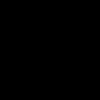

In [ ]:
cv2_imshow(images[0])

In [ ]:
images[0]

array([[[0.38431373, 0.43137255, 0.5568628 ],
        [0.4       , 0.43529412, 0.5568628 ],
        [0.4117647 , 0.44705883, 0.5686275 ],
        ...,
        [0.39215687, 0.42745098, 0.56078434],
        [0.39607844, 0.4392157 , 0.57254905],
        [0.4       , 0.43529412, 0.5686275 ]],

       [[0.39215687, 0.43137255, 0.56078434],
        [0.39215687, 0.44705883, 0.5686275 ],
        [0.41960785, 0.48235294, 0.5921569 ],
        ...,
        [0.4       , 0.43529412, 0.5686275 ],
        [0.3882353 , 0.4392157 , 0.56078434],
        [0.38431373, 0.44313726, 0.5568628 ]],

       [[0.38431373, 0.43529412, 0.5529412 ],
        [0.42745098, 0.5058824 , 0.6039216 ],
        [0.47843137, 0.56078434, 0.6431373 ],
        ...,
        [0.4       , 0.44313726, 0.56078434],
        [0.3764706 , 0.43137255, 0.54901963],
        [0.3647059 , 0.43529412, 0.54901963]],

       ...,

       [[0.40784314, 0.47843137, 0.5647059 ],
        [0.45882353, 0.5294118 , 0.58431375],
        [0.54509807, 0

### Split train, validation and test set

نمیشه بعد از تعریف دیتا جنریتور ولید را از آموزشی جدا کرد؟

In [ ]:
X , y = images, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify = y, random_state=3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify = y_train, random_state=3)
print(f'X_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'X_valid shape : {X_valid.shape}')
print(f'y_valid shape : {y_valid.shape}')
print(f'X_test shape : {X_test.shape}')
print(f'y_test shape : {y_test.shape}')

X_train shape : (210, 100, 100, 3)
y_train shape : (210, 2)
X_valid shape : (24, 100, 100, 3)
y_valid shape : (24, 2)
X_test shape : (26, 100, 100, 3)
y_test shape : (26, 2)


### Create data generator

ساختن دیتا جنریتور


افزایش داده باید بعد از تقسیم بندی داده ها به دو مجموعه آموزشی و تست انجام شود. برای اینکه کار ما با  دقت انجام شود باید مطمئن شویم که فقط داده های قسمت آموزشی را افزایش می دهیم. اگر این افزایش داده قبل از تقسیم داده ها به دو قسمت آموزشی و تست انجام شود در واقع داریم بخشی از اطلاعات داده های آموزشی را به داده های تست انتقال می دهیم و بنابراین باعث می شود شبکه دقتی متفاوت از دقت واقعی داشته باشد و بهتر جواب دهد.

In [ ]:
from skimage import exposure
# produce function for adaptive histogram equalization 
def HE(img): 
    img_eq = exposure.equalize_hist(img)
    return img_eq

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

In [ ]:
batch_size = 16
epochs = 300
Training_data = datagen.flow(X_train, y_train, batch_size = batch_size)

In [ ]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_accuracy',verbose=1, save_best_only=True)

## Create model1

#### using 2 neurons in last layer

In [ ]:
input_model = Input((X_train.shape[1],X_train.shape[2],X_train.shape[3]),name = 'input_layer')

model1 = Conv2D(16,(5,5), activation='relu', name = 'Conv1_5')(input_model)
model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
model1 = Dropout(rate = 0.4)(model1)
model1 = Conv2D(32,(5,5), activation='relu', name= 'Conv2_5')(model1)
model1 = MaxPooling2D((2, 2),name = 'MaxPool2')(model1)
model1 = Dropout(rate = 0.6)(model1)
model1 = Conv2D(64,(5,5), activation='relu', name = 'Conv3_3')(model1)
model1 = Dropout(rate = 0.8)(model1)
########################################################
model1 = Flatten(name = 'Flatten')(model1)
########################################################
output = Dense(units = 2, activation = 'softmax', name='preds')(model1)

model = Model(inputs= [input_model], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 Conv1_5 (Conv2D)            (None, 96, 96, 16)        1216      
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 48, 48, 16)        0         
                                                                 
 dropout (Dropout)           (None, 48, 48, 16)        0         
                                                                 
 Conv2_5 (Conv2D)            (None, 44, 44, 32)        12832     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 22, 22, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 32)        0     

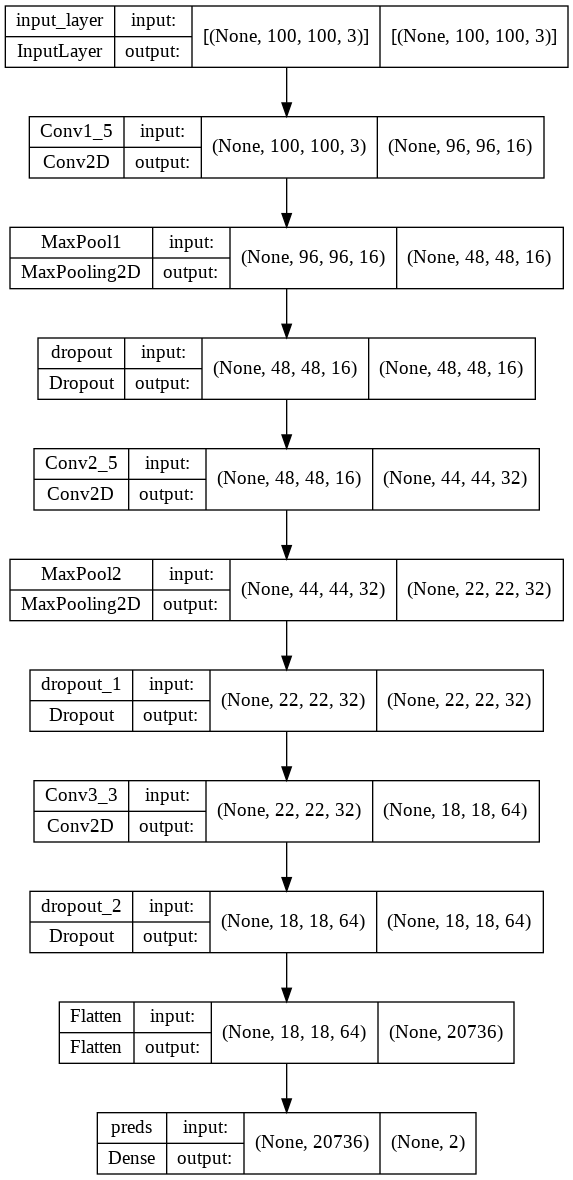

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
# sgd = SGD(learning_rate=0.001, momentum=0.9)
rmsp = RMSprop(learning_rate = 0.0001, decay = 1e-6)
model.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
n_samples = X_train.shape[0]

In [ ]:
history = model.fit(Training_data, epochs= epochs, validation_data= (X_valid, y_valid), steps_per_epoch= n_samples / batch_size, verbose=1, callbacks=[checkpointer])

Epoch 1/300
14/13 [================================] - ETA: 0s - loss: 0.7216 - accuracy: 0.4333
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to best_weights.hdf5
13/13 [==============================] - 5s 303ms/step - loss: 0.7216 - accuracy: 0.4333 - val_loss: 0.6920 - val_accuracy: 0.6250
Epoch 2/300
14/13 [================================] - ETA: 0s - loss: 0.6974 - accuracy: 0.5714
Epoch 2: val_accuracy did not improve from 0.62500
13/13 [==============================] - 4s 284ms/step - loss: 0.6974 - accuracy: 0.5714 - val_loss: 0.6921 - val_accuracy: 0.5833
Epoch 3/300
14/13 [================================] - ETA: 0s - loss: 0.7036 - accuracy: 0.5095
Epoch 3: val_accuracy improved from 0.62500 to 0.70833, saving model to best_weights.hdf5
13/13 [==============================] - 4s 285ms/step - loss: 0.7036 - accuracy: 0.5095 - val_loss: 0.6917 - val_accuracy: 0.7083
Epoch 4/300
14/13 [================================] - ETA: 0s - loss: 0.7023 - accuracy

In [ ]:
model.save_weights("model1_weights_hist.h5")
model.save("model1_hist.h5")

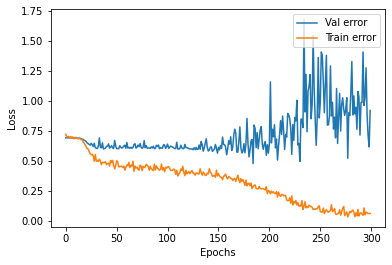

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']
# epochs = [i for i in range(epochs)]
plt.plot(val_loss)
plt.plot(loss)
# plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error1.png')
plt.show()

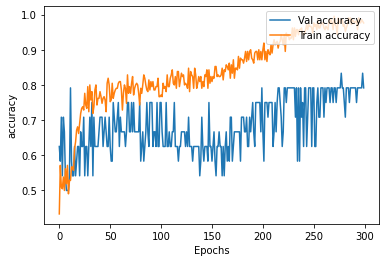

In [ ]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']
plt.plot(val_accuracy)
plt.plot(accuracy)
# plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val accuracy','Train accuracy'], loc='upper right')
plt.savefig( 'plot_accuracy1.png')
plt.show()

In [ ]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

2/2 [==============================] - 0s 42ms/step - loss: 0.9028 - accuracy: 0.8462
Test score: 0.9027610421180725
Test accuracy: 0.8461538553237915


In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_test = y_test.argmax(axis=1)
roc_auc_score(y_test, y_pred)

0.8461538461538461

## Create Model2

### Change preprocessing function 

in this part we don't use 2-d array for label.

In [6]:
def data_preprocessing(dataframe, dim):

  n = dataframe.shape[0]
  images = np.zeros((n,dim,dim,3),dtype = np.float32)
  labels = np.zeros((n,1),dtype = np.float32)
  for i in range(n):
    img = cv2.imread(str(dataframe.iloc[i]['image'])) 
    img = cv2.resize(img, (dim,dim))
    label = data.iloc[i]['label']
    orig_img = img.astype(np.float32)/255.           
    images[i] = orig_img
    labels[i] = label

  return images, labels

In [7]:
images, labels = data_preprocessing(data, 100)
print(f'images shape : {images.shape}')
print(f'labels shape : {labels.shape}')

images shape : (260, 100, 100, 3)
labels shape : (260, 1)


### Split train, valid and test set

In [8]:
X , y = images, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify = y, random_state=3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify = y_train, random_state=3)
print(f'X_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'X_valid shape : {X_valid.shape}')
print(f'y_valid shape : {y_valid.shape}')
print(f'X_test shape : {X_test.shape}')
print(f'y_test shape : {y_test.shape}')

X_train shape : (210, 100, 100, 3)
y_train shape : (210, 1)
X_valid shape : (24, 100, 100, 3)
y_valid shape : (24, 1)
X_test shape : (26, 100, 100, 3)
y_test shape : (26, 1)


In [9]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

In [ ]:
batch_size = 16
epochs = 300
n_samples = X_train.shape[0]
Training_data = datagen.flow(X_train, y_train, batch_size = batch_size)

In [ ]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_accuracy',verbose=1, save_best_only=True)

using 1 neuron in the last layer of the modle2

In [ ]:
input_model = Input((X_train.shape[1],X_train.shape[2],X_train.shape[3]),name = 'input_layer')

model1 = Conv2D(16,(5,5), activation='relu', name = 'Conv1_5')(input_model)
model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
model1 = Dropout(rate = 0.4)(model1)
model1 = Conv2D(32,(5,5), activation='relu', name= 'Conv2_5')(model1)
model1 = MaxPooling2D((2, 2),name = 'MaxPool2')(model1)
model1 = Dropout(rate = 0.6)(model1)
model1 = Conv2D(64,(5,5), activation='relu', name = 'Conv3_3')(model1)
model1 = Dropout(rate = 0.8)(model1)
########################################################
model1 = Flatten(name = 'Flatten')(model1)
########################################################
output = Dense(units = 1, activation = 'sigmoid', name='preds')(model1)

model = Model(inputs= [input_model], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 Conv1_5 (Conv2D)            (None, 96, 96, 16)        1216      
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 48, 48, 16)        0         
                                                                 
 dropout (Dropout)           (None, 48, 48, 16)        0         
                                                                 
 Conv2_5 (Conv2D)            (None, 44, 44, 32)        12832     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 22, 22, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 32)        0     

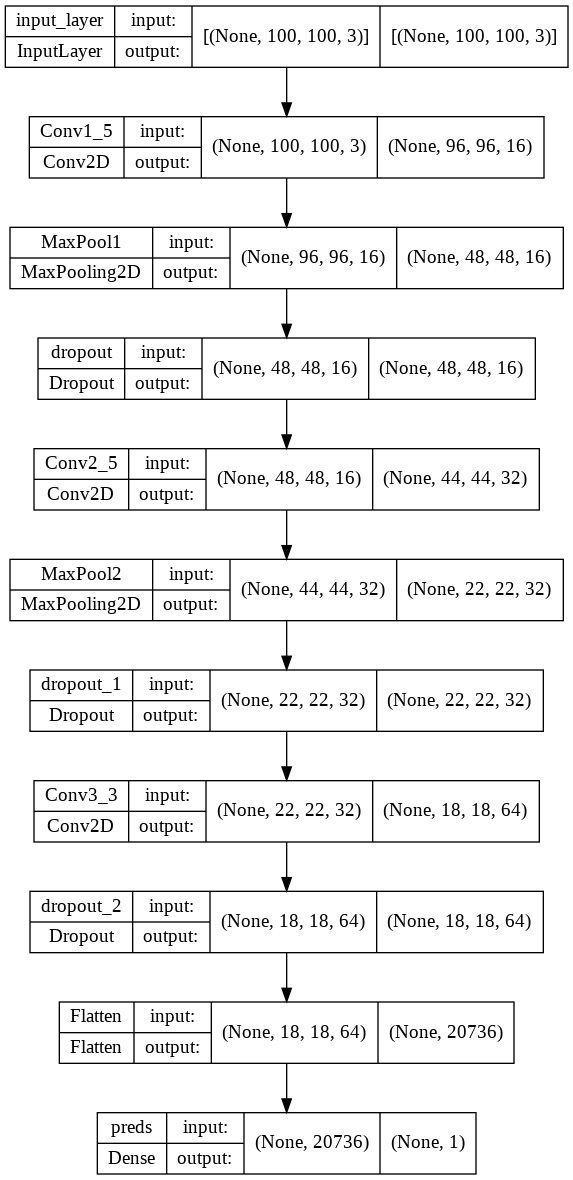

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
rmsp = RMSprop(learning_rate = 0.0001)
model.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(Training_data, epochs= epochs, validation_data= (X_valid, y_valid), steps_per_epoch= n_samples / batch_size, verbose=1, callbacks=[checkpointer])

Epoch 1/300
14/13 [================================] - ETA: 0s - loss: 0.7113 - accuracy: 0.5476
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_weights.hdf5
13/13 [==============================] - 6s 282ms/step - loss: 0.7113 - accuracy: 0.5476 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/300
14/13 [================================] - ETA: 0s - loss: 0.7100 - accuracy: 0.4762
Epoch 2: val_accuracy improved from 0.50000 to 0.58333, saving model to best_weights.hdf5
13/13 [==============================] - 4s 271ms/step - loss: 0.7100 - accuracy: 0.4762 - val_loss: 0.6924 - val_accuracy: 0.5833
Epoch 3/300
14/13 [================================] - ETA: 0s - loss: 0.6983 - accuracy: 0.4905
Epoch 3: val_accuracy improved from 0.58333 to 0.66667, saving model to best_weights.hdf5
13/13 [==============================] - 4s 266ms/step - loss: 0.6983 - accuracy: 0.4905 - val_loss: 0.6917 - val_accuracy: 0.6667
Epoch 4/300
14/13 [==============================

In [ ]:
model.save_weights("/content/drive/MyDrive/DIP/HW2/model1_weights_hist.h5")
model.save("/content/drive/MyDrive/DIP/HW2/model1_hist.h5")

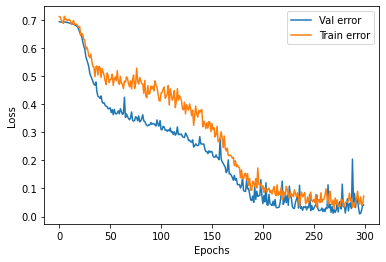

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']
# epochs = [i for i in range(epochs)]
plt.plot(val_loss)
plt.plot(loss)
# plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error1.png')
plt.show()

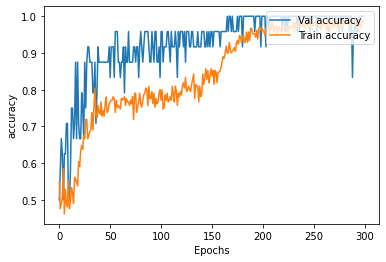

In [ ]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']
plt.plot(val_accuracy)
plt.plot(accuracy)
# plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val accuracy','Train accuracy'], loc='upper right')
plt.savefig( 'plot_accuracy1.png')
plt.show()

In [ ]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

2/2 [==============================] - 0s 85ms/step - loss: 0.0237 - accuracy: 1.0000
Test score: 0.023682434111833572
Test accuracy: 1.0


In [ ]:
from tensorflow import keras
model1 = keras.models.load_model('/content/drive/MyDrive/DIP/HW2/model1_hist.h5')

In [47]:
y_pred = model1.predict(X_test)
y_ac = (y_pred > 0.5)
y_ac = [int(i) for i in y_ac]
roc_auc_score(y_test, y_ac)

1.0

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_ac))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        13

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



## Create Model3

### define preprocessing function

This function is the same as preprocessing function for model2.

In [5]:
def data_preprocessing(dataframe, dim):

  n = dataframe.shape[0]
  images = np.zeros((n,dim,dim,3),dtype = np.float32)
  labels = np.zeros((n,1),dtype = np.float32)
  for i in range(n):
    img = cv2.imread(str(dataframe.iloc[i]['image'])) 
    img = cv2.resize(img, (dim,dim))
    label = data.iloc[i]['label']
    orig_img = img.astype(np.float32)/255.           
    images[i] = orig_img
    labels[i] = label

  return images, labels

In [6]:
images, labels = data_preprocessing(data, 100)
print(f'images shape : {images.shape}')
print(f'labels shape : {labels.shape}')

images shape : (260, 100, 100, 3)
labels shape : (260, 1)


### Split train, valid and test set

In [7]:
X , y = images, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify = y, random_state=3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify = y_train, random_state=3)
print(f'X_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'X_valid shape : {X_valid.shape}')
print(f'y_valid shape : {y_valid.shape}')
print(f'X_test shape : {X_test.shape}')
print(f'y_test shape : {y_test.shape}')

X_train shape : (210, 100, 100, 3)
y_train shape : (210, 1)
X_valid shape : (24, 100, 100, 3)
y_valid shape : (24, 1)
X_test shape : (26, 100, 100, 3)
y_test shape : (26, 1)


In [8]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

increase the batch size

In [9]:
batch_size = 32
epochs = 300
n_samples = X_train.shape[0]
Training_data = datagen.flow(X_train, y_train, batch_size = batch_size)

In [10]:
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/DIP/HW2/best_weights.hdf5", monitor = 'val_accuracy',verbose=1, save_best_only=True)

In [11]:
input_model = Input((X_train.shape[1],X_train.shape[2],X_train.shape[3]),name = 'input_layer')

model1 = Conv2D(16,(5,5), activation='relu', name = 'Conv1_5')(input_model)
model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
model1 = Dropout(rate = 0.4)(model1)
model1 = Conv2D(32,(5,5), activation='relu', name= 'Conv2_5')(model1)
model1 = MaxPooling2D((2, 2),name = 'MaxPool2')(model1)
model1 = Dropout(rate = 0.6)(model1)
model1 = Conv2D(64,(5,5), activation='relu', name = 'Conv3_3')(model1)
model1 = Dropout(rate = 0.8)(model1)
########################################################
model1 = Flatten(name = 'Flatten')(model1)
########################################################
output = Dense(units = 1, activation = 'sigmoid', name='preds')(model1)

model = Model(inputs= [input_model], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 Conv1_5 (Conv2D)            (None, 96, 96, 16)        1216      
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 48, 48, 16)        0         
                                                                 
 dropout (Dropout)           (None, 48, 48, 16)        0         
                                                                 
 Conv2_5 (Conv2D)            (None, 44, 44, 32)        12832     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 22, 22, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 32)        0     

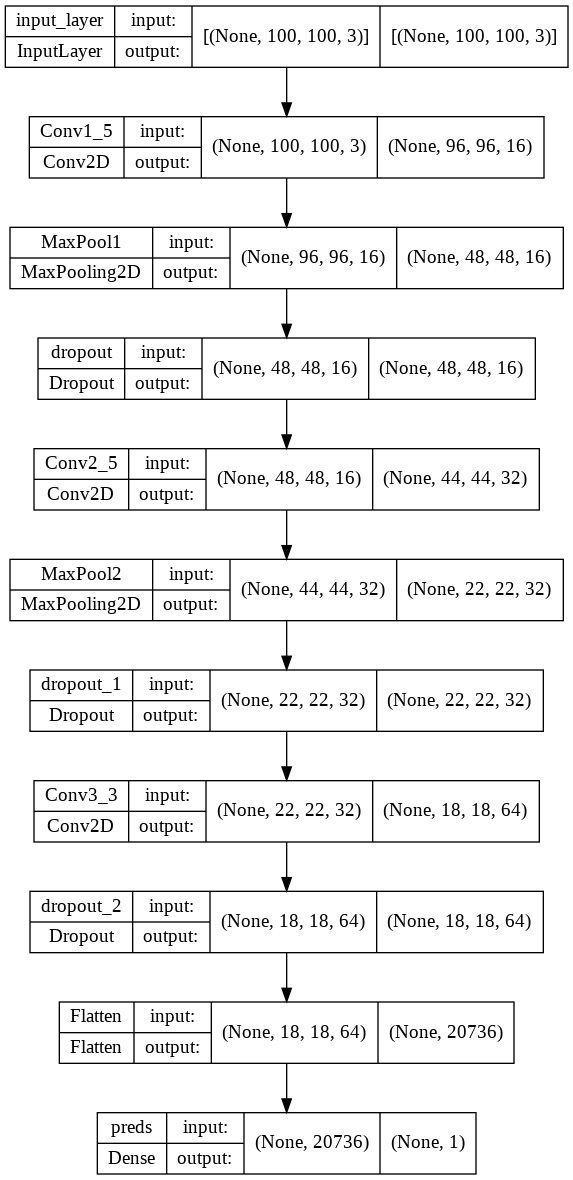

In [12]:
plot_model(model, show_shapes=True)

In [13]:
# sgd = SGD(learning_rate=0.001, momentum=0.9)
rmsp = RMSprop(learning_rate = 0.0001)
model.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(Training_data, epochs= epochs, validation_data= (X_valid, y_valid), steps_per_epoch= n_samples / batch_size, verbose=1, callbacks=[checkpointer])

Epoch 1/300
7/6 [================================] - ETA: 0s - loss: 0.7399 - accuracy: 0.4905
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/DIP/HW2/best_weights.hdf5
6/6 [==============================] - 5s 603ms/step - loss: 0.7399 - accuracy: 0.4905 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/300
7/6 [================================] - ETA: 0s - loss: 0.7081 - accuracy: 0.4905
Epoch 2: val_accuracy did not improve from 0.50000
6/6 [==============================] - 4s 565ms/step - loss: 0.7081 - accuracy: 0.4905 - val_loss: 0.6927 - val_accuracy: 0.4167
Epoch 3/300
7/6 [================================] - ETA: 0s - loss: 0.7169 - accuracy: 0.4619
Epoch 3: val_accuracy improved from 0.50000 to 0.58333, saving model to /content/drive/MyDrive/DIP/HW2/best_weights.hdf5
6/6 [==============================] - 4s 570ms/step - loss: 0.7169 - accuracy: 0.4619 - val_loss: 0.6919 - val_accuracy: 0.5833
Epoch 4/300
7/6 [=====================

In [15]:
model.save_weights("/content/drive/MyDrive/DIP/HW2/model2_weights_hist.h5")
model.save("/content/drive/MyDrive/DIP/HW2/model2_hist.h5")

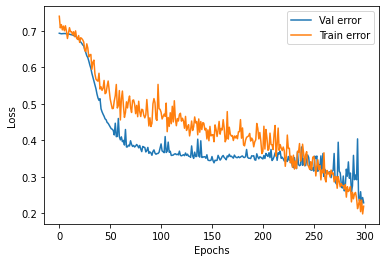

In [16]:
val_loss = history.history['val_loss']
loss = history.history['loss']
plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error1.png')
plt.show()

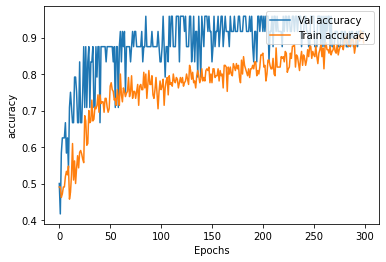

In [17]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']
plt.plot(val_accuracy)
plt.plot(accuracy)
# plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val accuracy','Train accuracy'], loc='upper right')
plt.savefig( 'plot_accuracy1.png')
plt.show()

In [18]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

1/1 [==============================] - 0s 114ms/step - loss: 0.2515 - accuracy: 0.9615
Test score: 0.2515067458152771
Test accuracy: 0.9615384340286255


In [25]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_ac]
roc_auc_score(y_test, y_ac)

0.9615384615384616

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_ac))

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        13
         1.0       0.93      1.00      0.96        13

    accuracy                           0.96        26
   macro avg       0.96      0.96      0.96        26
weighted avg       0.96      0.96      0.96        26



## Create Model4

The preprocessing function is the same as the model2 and model3.


increase the batch size 

In [27]:
batch_size = 64
epochs = 300
n_samples = X_train.shape[0]
Training_data = datagen.flow(X_train, y_train, batch_size = batch_size)

In [28]:
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/DIP/HW2/best_weights3.hdf5", monitor = 'val_accuracy',verbose=1, save_best_only=True)

In [29]:
input_model = Input((X_train.shape[1],X_train.shape[2],X_train.shape[3]),name = 'input_layer')

model1 = Conv2D(16,(5,5), activation='relu', name = 'Conv1_5')(input_model)
model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
model1 = Dropout(rate = 0.4)(model1)
model1 = Conv2D(32,(5,5), activation='relu', name= 'Conv2_5')(model1)
model1 = MaxPooling2D((2, 2),name = 'MaxPool2')(model1)
model1 = Dropout(rate = 0.6)(model1)
model1 = Conv2D(64,(5,5), activation='relu', name = 'Conv3_3')(model1)
model1 = Dropout(rate = 0.8)(model1)
########################################################
model1 = Flatten(name = 'Flatten')(model1)
########################################################
output = Dense(units = 1, activation = 'sigmoid', name='preds')(model1)

model = Model(inputs= [input_model], outputs=[output])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 Conv1_5 (Conv2D)            (None, 96, 96, 16)        1216      
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 48, 48, 16)        0         
                                                                 
 dropout_3 (Dropout)         (None, 48, 48, 16)        0         
                                                                 
 Conv2_5 (Conv2D)            (None, 44, 44, 32)        12832     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 22, 22, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 22, 22, 32)        0   

In [30]:
# sgd = SGD(learning_rate=0.001, momentum=0.9)
rmsp = RMSprop(learning_rate = 0.0001)
model.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
history = model.fit(Training_data, epochs= epochs, validation_data= (X_valid, y_valid), steps_per_epoch= n_samples / batch_size, verbose=1, callbacks=[checkpointer])

Epoch 1/300
4/3 [====================================] - ETA: 0s - loss: 0.7379 - accuracy: 0.4810
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to /content/drive/MyDrive/DIP/HW2/best_weights3.hdf5
3/3 [==============================] - 5s 2s/step - loss: 0.7379 - accuracy: 0.4810 - val_loss: 0.6940 - val_accuracy: 0.4167
Epoch 2/300
4/3 [====================================] - ETA: 0s - loss: 0.7238 - accuracy: 0.4619
Epoch 2: val_accuracy improved from 0.41667 to 0.58333, saving model to /content/drive/MyDrive/DIP/HW2/best_weights3.hdf5
3/3 [==============================] - 5s 2s/step - loss: 0.7238 - accuracy: 0.4619 - val_loss: 0.6927 - val_accuracy: 0.5833
Epoch 3/300
4/3 [====================================] - ETA: 0s - loss: 0.7217 - accuracy: 0.4619
Epoch 3: val_accuracy did not improve from 0.58333
3/3 [==============================] - 4s 1s/step - loss: 0.7217 - accuracy: 0.4619 - val_loss: 0.6919 - val_accuracy: 0.5417
Epoch 4/300
4/3 [================

In [32]:
model.save_weights("/content/drive/MyDrive/DIP/HW2/model3_weights_hist.h5")
model.save("/content/drive/MyDrive/DIP/HW2/model3_hist.h5")

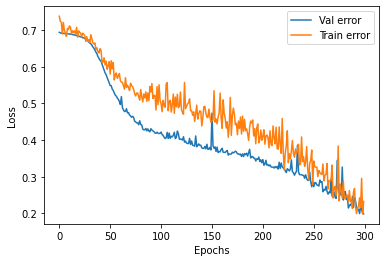

In [33]:
val_loss = history.history['val_loss']
loss = history.history['loss']
plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error1.png')
plt.show()

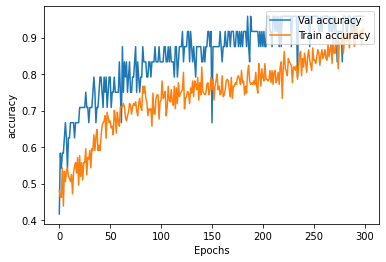

In [34]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']
plt.plot(val_accuracy)
plt.plot(accuracy)
# plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val accuracy','Train accuracy'], loc='upper right')
plt.savefig( 'plot_accuracy1.png')
plt.show()

In [35]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

1/1 [==============================] - 0s 110ms/step - loss: 0.1878 - accuracy: 1.0000
Test score: 0.18779951333999634
Test accuracy: 1.0


In [10]:
from tensorflow import keras
model4 = keras.models.load_model('/content/drive/MyDrive/DIP/HW2/model3_hist.h5')

In [13]:
y_pred = model4.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
roc_auc_score(y_test, y_pred)

1.0

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        13

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



## Notice

In [ ]:
batch normalizaiton

In [42]:
# decay

learning rate scheduler

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)


## Create Model5

In [19]:
batch_size = 64
epochs = 300
n_samples = X_train.shape[0]
Training_data = datagen.flow(X_train, y_train, batch_size = batch_size)

In [20]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/DIP/HW2/best_weights5.hdf5", monitor = 'val_accuracy',verbose=1, save_best_only=True)

In [21]:
input_model = Input((X_train.shape[1],X_train.shape[2],X_train.shape[3]),name = 'input_layer')

model1 = Conv2D(16,(5,5), activation='relu', name = 'Conv1_5')(input_model)
model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
model1 = Dropout(rate = 0.4)(model1)
model1 = Conv2D(32,(5,5), activation='relu', name= 'Conv2_5')(model1)
model1 = MaxPooling2D((2, 2),name = 'MaxPool2')(model1)
model1 = Dropout(rate = 0.6)(model1)
model1 = Conv2D(64,(5,5), activation='relu', name = 'Conv3_3')(model1)
model1 = Dropout(rate = 0.8)(model1)
########################################################
model1 = Flatten(name = 'Flatten')(model1)
########################################################
output = Dense(units = 1, activation = 'sigmoid', name='preds')(model1)

model = Model(inputs= [input_model], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 Conv1_5 (Conv2D)            (None, 96, 96, 16)        1216      
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 48, 48, 16)        0         
                                                                 
 dropout (Dropout)           (None, 48, 48, 16)        0         
                                                                 
 Conv2_5 (Conv2D)            (None, 44, 44, 32)        12832     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 22, 22, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 32)        0     

In [22]:
rmsp = RMSprop(learning_rate = 0.0001)
model.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(Training_data, epochs= epochs, validation_data= (X_valid, y_valid), steps_per_epoch= n_samples / batch_size, verbose=1, callbacks=[checkpointer, reduce_lr])

Epoch 1/300
4/3 [====================================] - ETA: 0s - loss: 0.7061 - accuracy: 0.5429
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to /content/drive/MyDrive/DIP/HW2/best_weights5.hdf5
3/3 [==============================] - 6s 1s/step - loss: 0.7061 - accuracy: 0.5429 - val_loss: 0.6946 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/300
4/3 [====================================] - ETA: 0s - loss: 0.7176 - accuracy: 0.5048
Epoch 2: val_accuracy improved from 0.25000 to 0.50000, saving model to /content/drive/MyDrive/DIP/HW2/best_weights5.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.7176 - accuracy: 0.5048 - val_loss: 0.6939 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/300
4/3 [====================================] - ETA: 0s - loss: 0.7027 - accuracy: 0.4905
Epoch 3: val_accuracy did not improve from 0.50000
3/3 [==============================] - 3s 929ms/step - loss: 0.7027 - accuracy: 0.4905 - val_loss: 0.6932 - val_accuracy: 0.5

In [24]:
model.save_weights("/content/drive/MyDrive/DIP/HW2/model5_weights_hist.h5")
model.save("/content/drive/MyDrive/DIP/HW2/model5_hist.h5")

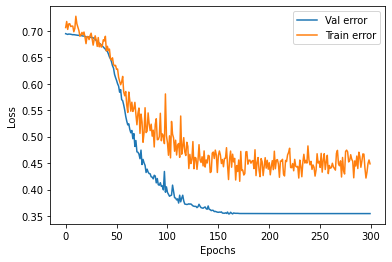

In [25]:
val_loss = history.history['val_loss']
loss = history.history['loss']
plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error1.png')
plt.show()

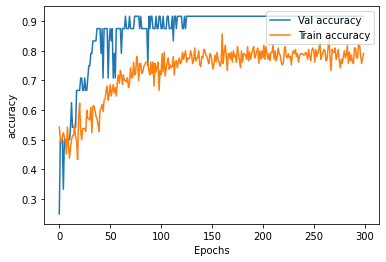

In [26]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']
plt.plot(val_accuracy)
plt.plot(accuracy)
# plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val accuracy','Train accuracy'], loc='upper right')
plt.savefig( 'plot_accuracy1.png')
plt.show()

In [27]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

1/1 [==============================] - 0s 95ms/step - loss: 0.5798 - accuracy: 0.7308
Test score: 0.5798132419586182
Test accuracy: 0.7307692170143127


In [30]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
roc_auc_score(y_test, y_pred)

0.7307692307692308

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.62      0.70        13
         1.0       0.69      0.85      0.76        13

    accuracy                           0.73        26
   macro avg       0.74      0.73      0.73        26
weighted avg       0.74      0.73      0.73        26



مدل ۶ اولش بیام نرخ یادگیری رو ۰.۰۱ قرار بدهم و به تدریج کمش بکنم